In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
import seaborn as sns



In [2]:
df_train = pd.read_csv('train.csv')
df_train = df_train.drop(columns=['id'])

df_test = pd.read_csv('test.csv')
df_test = df_test.drop(columns=['id'])

In [3]:
df_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f282,f283,f284,f285,f286,f287,f288,f289,f290,target
0,2014-01-29,69,38.0,7.0,10.0,1.0,2001.0,2.0,11.0,2.0,...,1,0,0,2,8,1,0,19,2,9500000
1,2014-04-07,55,NaN,2.0,1.0,4.0,NaN,2.0,10.0,NaN,...,0,0,0,0,4,0,0,2,0,3837949
2,2012-05-18,30,16.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,46,9,2,11,38,1,8,97,11,6250000
3,2013-02-08,44,43.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,17,4,1,12,12,0,1,55,7,2000000
4,2014-01-10,45,28.0,3.0,5.0,2.0,1960.0,2.0,5.0,NaN,...,20,2,0,4,16,1,4,47,5,6700000


## Target

видим скачок таргета для небольшого числа объектов

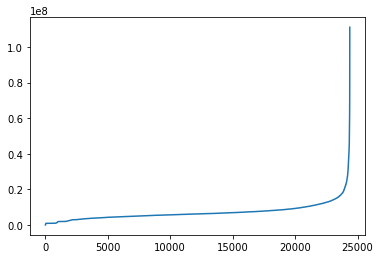

In [5]:
plt.plot(sorted(df_train['target']))

<AxesSubplot:>

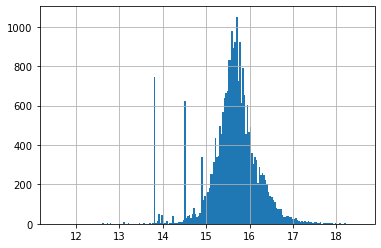

In [6]:
np.log(df_train['target']).hist(bins = 200)

In [7]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
print('train_size',ntrain)
print('test_size',ntest)

train_size 24376
test_size 6095


In [ ]:
def transform(data):
    tfm_data = data.copy()
    tfm_data['f1'] = pd.to_datetime(tfm_data['f1'])
    tfm_data['f1_year'] = tfm_data['f1'].dt.year
    tfm_data['f1_month'] = tfm_data['f1'].dt.month
    tfm_data['f1_day'] = tfm_data['f1'].dt.day
    tfm_data = tfm_data.drop(columns=['f1'])
    
    tfm_data = pd.get_dummies(tfm_data, columns=['f11','f29','f33','f34','f35',
                                                               'f36','f37','f38','f39','f40','f106','f114','f118'], 
                                 prefix = ['f11','f29','f33','f34','f35',
                                                               'f36','f37','f38','f39','f40','f106','f114','f118'])
    tfm_data["first"] = (tfm_data['f12'].apply(lambda x : 
                               x in ['Poselenie Sosenskoe','Nekrasovka','Poselenie Vnukovskoe','Poselenie Moskovskij'])).apply(int)
    tfm_data["second"] = tfm_data['f12'].apply(lambda x : 
                               x not in ['Poselenie Sosenskoe','Nekrasovka','Poselenie Vnukovskoe','Poselenie Moskovskij']).apply(int)
    tfm_data = tfm_data.drop(columns=['f12'])
    
    rep_map = {'f152': {'excellent': 5, 'good': 4, 'satisfactory': 3, 'poor': 2,'no data': 1}}
    tfm_data = tfm_data.replace(rep_map)
    return tfm_data
    

In [ ]:
def missing(data):
    tfm_data = data.copy()
    # много пропусков
    tfm_data = tfm_data.drop(columns=['f7'])
    tfm_data = tfm_data.drop(columns=['f10'])
    tfm_data = tfm_data.drop(columns=['f24'])
    tfm_data = tfm_data.drop(columns=['f160'])
    tfm_data = tfm_data.drop(columns=['f161'])
    tfm_data = tfm_data.drop(columns=['f162'])
    
    #удалить f6      7650 
    #        f8      7650
    tfm_data = tfm_data.drop(columns=['f6'])
    tfm_data = tfm_data.drop(columns=['f8'])
    
    tfm_data['f77'] = tfm_data['f77'].fillna(0)
    
    tfm_data = tfm_data.fillna(tfm_data.median())
    
    
    
    return tfm_data

    

In [ ]:
y_train = df_train.target.values
train_data = df_train.copy()
test_data = df_test.copy()
train_data.drop(['target'], axis=1, inplace=True)
print("train_data size is : {}".format(train_data.shape))

In [ ]:
train_data_na = (train_data.isnull().sum() / len(train_data)) * 100
train_data_na = train_data_na.drop(train_data_na[train_data_na ==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_data_na})
missing_data

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_data_na.index, y=train_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Преобразуем признак ф1 

In [ ]:
train_data['f1'] = pd.to_datetime(train_data['f1'])
train_data['f1_year'] = train_data['f1'].dt.year
train_data['f1_month'] = train_data['f1'].dt.month
train_data['f1_day'] = train_data['f1'].dt.day
train_data = train_data.drop(columns=['f1'])

In [ ]:
train_data.head()

In [ ]:
train_data.dtypes.value_counts()

## object тип

In [ ]:
train_data[train_data.dtypes[train_data.dtypes == object].index]

In [ ]:
train_data_tf = transform(train_data)
test_data_tf = transform(test_data)

In [ ]:
train_data_tf.shape, test_data_tf.shape

In [ ]:
ftest_data = missing(test_data_tf)
ftrain_data = missing(train_data_tf)


In [ ]:
def funn(X,y):
    X=X.to_numpy()
    mean = np.log(y).mean()
    std = np.log(y).std()
    a = mean - 2*std
    b = mean + 2*std
    
    return X[np.where((np.log(y)<b)&(np.log(y)>a))], y[(np.where((np.log(y)<b)&(np.log(y)>a)))]

    
    

In [ ]:
new_t_x, new_t_y =  funn(ftrain_data,y_train)

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="median")
result_data = imp.fit_transform(result_data)

In [ ]:
result_data[0]

In [ ]:
x_train = result_data[:ntrain]
x_test = result_data[:ntest]

In [ ]:
print(x_train.shape,x_test.shape, y_train.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [ ]:
print(X_train.shape,X_test.shape)

In [ ]:
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score



In [ ]:
model = RandomForestRegressor(n_estimators=6, max_depth=2, random_state=0)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
#print(model.score(X_train, Y_train), model.score(X_test, Y_test))
#print(classification_report(Y_test, model.predict(X_test)))

In [ ]:
x_train

In [ ]:
y_train.shape

In [ ]:
def funn(X,y):
    mean = np.log(y).mean()
    std = np.log(y).std()
    a = mean - 2*std
    b = mean + 2*std
    
    return X[np.where((np.log(y)<b)&(np.log(y)>a))], y[(np.where((np.log(y)<b)&(np.log(y)>a)))]
x_new,y_new = funn(x_train,y_train)
    
    

In [ ]:
model = RandomForestRegressor(n_estimators=6, max_depth=2, random_state=0)
n_scores = cross_val_score(model, ftrain_data, y_train, cv=10, n_jobs=-1,scoring='neg_mean_squared_log_error')
print(n_scores)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
model_cb = CatBoostRegressor()
n_scores = cross_val_score(model_cb, ftrain_data, y_train, cv=10, n_jobs=-1,scoring='neg_mean_squared_log_error')
print(n_scores)
print('SCORE: %.2f (%.2f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
print(mean_squared_log_error(Y_test, y_pred))
print(mean_squared_log_error(Y_test, y_pred_cb))
print(mean_squared_log_error(Y_test, y_pred_xg))
print(mean_squared_log_error(Y_test, y_pred_lg))



In [ ]:
plt.plot(Y_test[50:100],'r')
plt.plot(y_pred_xg[50:100],'g')
plt.plot(y_pred_cb[50:100],'y')
plt.plot(y_pred_lg[50:100],'b')



In [ ]:
# Initialize data

# Initialize CatBoostRegressor
model_cb = CatBoostRegressor()
# Fit model
model_cb.fit(new_t_x, new_t_y)
y_pred_cb = model_cb.predict(ftest_data)

In [ ]:
x_test.shape

In [ ]:

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)


print('Starting predicting...')
# predict
y_pred_lg = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval


In [ ]:
import xgboost as xgb



xgb.__version__

In [ ]:
model_xg = XGBRegressor()
# Fit model
model_xg.fit(X_train, Y_train)
y_pred_xg = model_xg.predict(X_test)

In [ ]:
model = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
...
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [ ]:
from sklearn.datasets import make_classification

In [ ]:

train_data = lgb.Dataset(X, label=y)
param = {'num_leaves': 31, 
         'objective': 'multiclass', 
         'num_class': 2, 
         'metric': ['multi_logloss']}

num_round = 10
bst = lgb.train(param, train_data, num_boost_round=10)

(bst.predict(X).argmax(axis=-1) == y).mean()

In [ ]:
all_data_dum = pd.get_dummies(all_data)

In [ ]:
all_data_dum

In [ ]:
train = all_data_dum[:ntrain]
test = all_data_dum[ntrain:]

In [ ]:
from catboost import CatBoostRegressor
# Initialize data

# Initialize CatBoostRegressor
model = CatBoostRegressor()
# Fit model
model.fit(train, y_train)
# Get predictions
preds = model.predict(test)

In [ ]:
plt.plot(sorted(preds))

In [ ]:
preds = np.expm1(preds)

In [ ]:
import pip

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

In [ ]:
col = np.array(range(1,len(y_pred_cb)+1))
result = np.c_[col,y_pred_cb]
print(result)
with open("sample_sabmission.csv", "wb") as f:
    f.write(b'id,prediction\n')
    np.savetxt(f, result, fmt='%i', delimiter=",")